# Summary:
This notebook will combine `Gene` and `Variation` information with **Latent Semantic Analysis (LSA)**. One-hot-encoding and **Truncated singular value decomposition (SVD)** is applied to transform `Gene` and `Variation` data. The obtained matrix is concatenated with the output of LSA from the previous notebook. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the combined matrix containing information about both text and gene variation.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[2.5 Latent Semantic Analysis (LSA) + Gene Variation](#Part2.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.1 Convert Gene and Variation](#Part2.5.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.2 LogisticRegression](#Part2.5.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.2.1 validation_curve](#Part2.5.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.2.2 Model evaluation](#Part2.5.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.3 RandomForestClassifier](#Part2.5.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.3.1 validation_curve](#Part2.5.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.3.2 Model evaluation](#Part2.5.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.4 XGBClassifier](#Part2.5.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5.4.1 validation_curve](#Part2.5.4.1_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [6]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

LSA models were trained in HPC with n_components=25, 50, 100, 200, 300 for both CountVectorizer and TfidfVectorizer. Files with reduced dimensions are uploaded here.

In [10]:
train_svd_count25=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim25.csv')).to_numpy()
train_svd_count50=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim50.csv')).to_numpy()
train_svd_count100=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim100.csv')).to_numpy()
train_svd_count200=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim200.csv')).to_numpy()
train_svd_count300=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim300.csv')).to_numpy()

train_svd_tfidf25=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim25.csv')).to_numpy()
train_svd_tfidf50=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim50.csv')).to_numpy()
train_svd_tfidf100=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim100.csv')).to_numpy()
train_svd_tfidf200=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim200.csv')).to_numpy()
train_svd_tfidf300=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim300.csv')).to_numpy()

In [11]:
print('train_svd_count25.shape: {}'.format(train_svd_count25.shape))
print('train_svd_count50.shape: {}'.format(train_svd_count50.shape))
print('train_svd_count100.shape: {}'.format(train_svd_count100.shape))
print('train_svd_count200.shape: {}'.format(train_svd_count200.shape))
print('train_svd_count300.shape: {}'.format(train_svd_count300.shape))
print('-'*50)
print('train_svd_tfidf25.shape: {}'.format(train_svd_tfidf25.shape))
print('train_svd_tfidf50.shape: {}'.format(train_svd_tfidf50.shape))
print('train_svd_tfidf100.shape: {}'.format(train_svd_tfidf100.shape))
print('train_svd_tfidf200.shape: {}'.format(train_svd_tfidf200.shape))
print('train_svd_tfidf300.shape: {}'.format(train_svd_tfidf300.shape))

train_svd_count25.shape: (3316, 25)
train_svd_count50.shape: (3316, 50)
train_svd_count100.shape: (3316, 100)
train_svd_count200.shape: (3316, 200)
train_svd_count300.shape: (3316, 300)
--------------------------------------------------
train_svd_tfidf25.shape: (3316, 25)
train_svd_tfidf50.shape: (3316, 50)
train_svd_tfidf100.shape: (3316, 100)
train_svd_tfidf200.shape: (3316, 200)
train_svd_tfidf300.shape: (3316, 300)


<a id='Part2.5_link'></a>
## 2.5 Latent Semantic Analysis (LSA) + Gene Variation

`Gene` and `Variation` may also contribute to classification. The huge size of the sparse count matrix obtained from `CountVectorizer` and `TfidfVectorizer` makes it difficult to include these two fields. Here, we can first transform `Gene` and `Variation` with one-hot-encoding and TruncatedSVD. The obtained output is concatenated with the output of LSA from the previous notebook. Machine learning models can then be applied to the combined vectors containing information about both text and gene variation. 

<a id='Part2.5.1_link'></a>
### 2.5.1 Convert Gene and Variation

In [14]:
data_df=train_df.append(test_df, ignore_index=True, sort=False)
one_hot_gene=pd.get_dummies(data_df.Gene)
one_hot_variation=pd.get_dummies(data_df.Variation)
print('one_hot_gene.shape: {}'.format(one_hot_gene.shape))
print('one_hot_variation: {}'.format(one_hot_variation.shape))

one_hot_gene.shape: (8983, 1505)
one_hot_variation: (8983, 8606)


In [15]:
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_gene_truncated=svd.fit_transform(one_hot_gene.values)
print('one_hot_gene_truncated.shape: {}'.format(one_hot_gene_truncated.shape))

one_hot_gene_truncated.shape: (8983, 25)


In [16]:
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
one_hot_variation_truncated=svd.fit_transform(one_hot_variation.values)
print('one_hot_variation_truncated.shape: {}'.format(one_hot_variation_truncated.shape))

one_hot_variation_truncated.shape: (8983, 25)


Here I will use `train_svd_count50`.

In [24]:
train_set=np.concatenate((one_hot_gene_truncated[:len(train_df)],one_hot_variation_truncated[:len(train_df)],train_svd_count50), axis=1)
print('train_set.shape: {}'.format(train_set.shape))

train_set.shape: (3316, 100)


<a id='Part2.5.2_link'></a>
### 2.5.2 LogisticRegression

<a id='Part2.5.2.1_link'></a>
### 2.5.2.1 validation_curve

In [18]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1)
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1)
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

* Model: TruncatedSVD + StandardScaler + LogisticRegression

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.54328342 0.54448923 0.55150066 0.56521795 0.57999366 0.59477316
 0.61730843 0.63653673 0.64347399 0.64732157 0.64928196 0.65252499]
test_mean: [0.41390883 0.41542624 0.41753882 0.42663238 0.4244945  0.40631927
 0.40026556 0.39035769 0.37830965 0.38127711 0.37435101 0.36623689]
--------------------------------------------------------------------------------
C: 0.0002310129700083158 achieves highest test score: 0.42663237640060175
--------------------------------------------------------------------------------


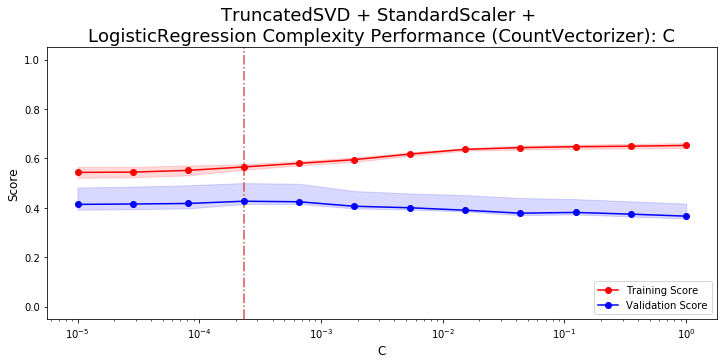

In [42]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_set)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD + StandardScaler + \nLogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

**Colusion for LogisticRegression**: 
<br>The performance is slightly better than the LSA without gene and variation information.

<a id='Part2.5.2.2_link'></a>
### 2.5.2.2 Model evaluation

Here are some functions used in model evaluation.

In [26]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [27]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [28]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [29]:
def plot_ROC_curve(acc_df):
    probas=np.array(acc_df.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

* Model: TruncatedSVD + StandardScaler + LogisticRegression(0.0002)

In [43]:
ss = StandardScaler(with_mean=False)
clf=LogisticRegression(C=0.0002,n_jobs=-1,random_state=8)
X=ss.fit_transform(train_set)
y=train_df.Class.values
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s


accuracy score: 0.4279252110977081
log_loss: 2.1280575167881306


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


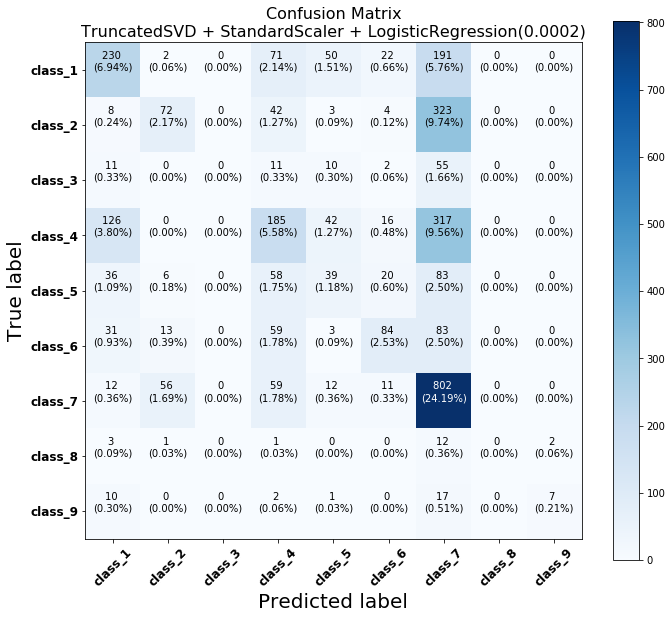

In [45]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nTruncatedSVD + StandardScaler + LogisticRegression(0.0002)', cmap=plt.cm.Blues)

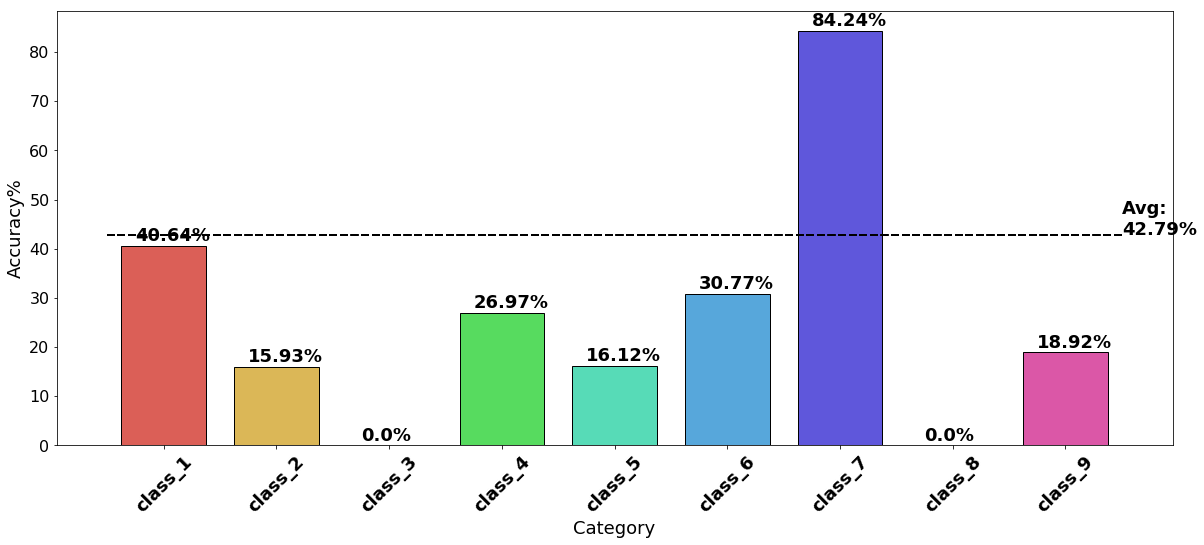

In [46]:
plot_acc_bar(cm,total_acc=42.79)

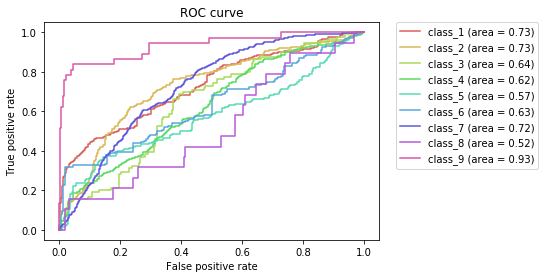

In [47]:
plot_ROC_curve(output)

<a id='Part2.5.3_link'></a>
### 2.5.3 RandomForestClassifier

<a id='Part2.5.3.1_link'></a>
### 2.5.3.1 validation_curve

* Model: TruncatedSVD + RandomForestClassifier

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.33000225 0.45920599 0.56709286 0.78256569 0.9016901  0.90335025
 0.90335025 0.90335025]
test_mean: [0.28893074 0.33309482 0.3834744  0.4244263  0.38972102 0.38914594
 0.38914594 0.38914594]
--------------------------------------------------------------------------------
max_depth: 10 achieves highest test score: 0.4244263041642299
--------------------------------------------------------------------------------


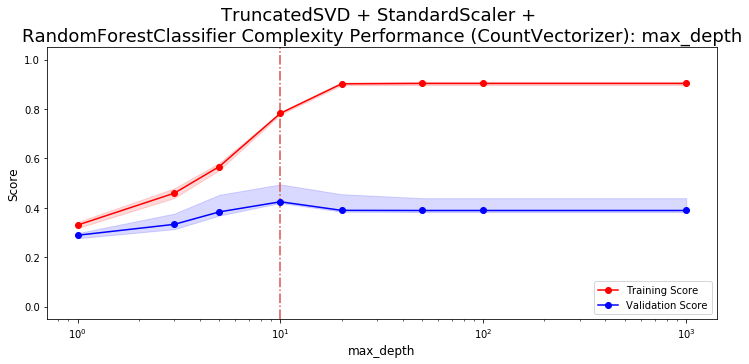

In [48]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.90335025 0.81031638 0.70454518 0.51697652 0.39745988 0.35283345]
test_mean: [0.38914594 0.41983427 0.4325978  0.37883875 0.31571962 0.31284615]
--------------------------------------------------------------------------------
min_samples_leaf: 15 achieves highest test score: 0.4325978048811721
--------------------------------------------------------------------------------


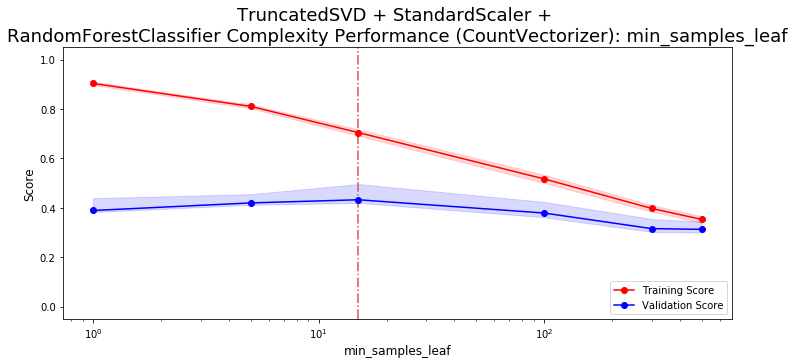

In [49]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

**Colusion for RandomForestClassifier**: 
1. The training performance is comparable between CountVectorizer and TfidfVectorizer.
2. Larger max_depth and smaller min_samples_leaf lead to overfitting.
3. CountVectorizer with TruncatedSVD(n_components=50) achieves the best performance with min_samples_leaf=15 for RandomForestClassifier.

<a id='Part2.5.3.2_link'></a>
### 2.5.3.2 Model evaluation

* Model: TruncatedSVD + RandomForestClassifier(max_depth=10,min_samples_leaf=15)

In [50]:
clf=RandomForestClassifier(max_depth=10,min_samples_leaf=15,n_jobs=-1,random_state=8)
X=train_set
y=train_df.Class.values

In [51]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.3953558504221954
log_loss: 1.7229752395753446


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


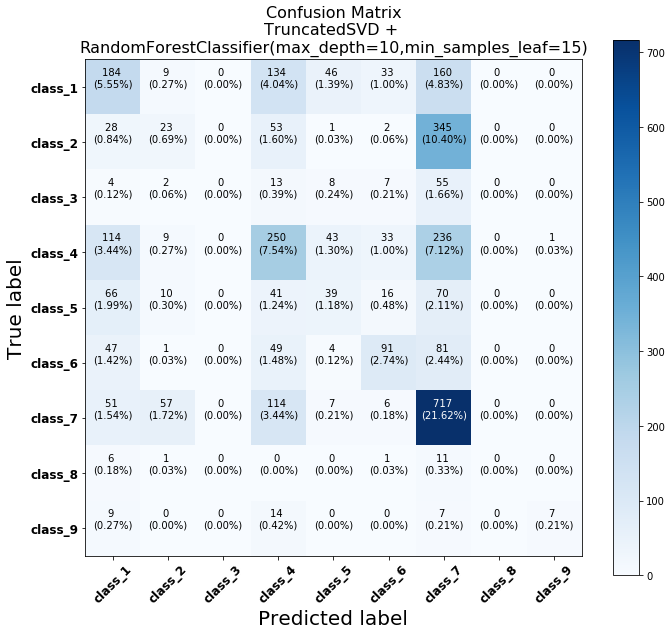

In [52]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nTruncatedSVD + \nRandomForestClassifier(max_depth=10,min_samples_leaf=15)', cmap=plt.cm.Blues)

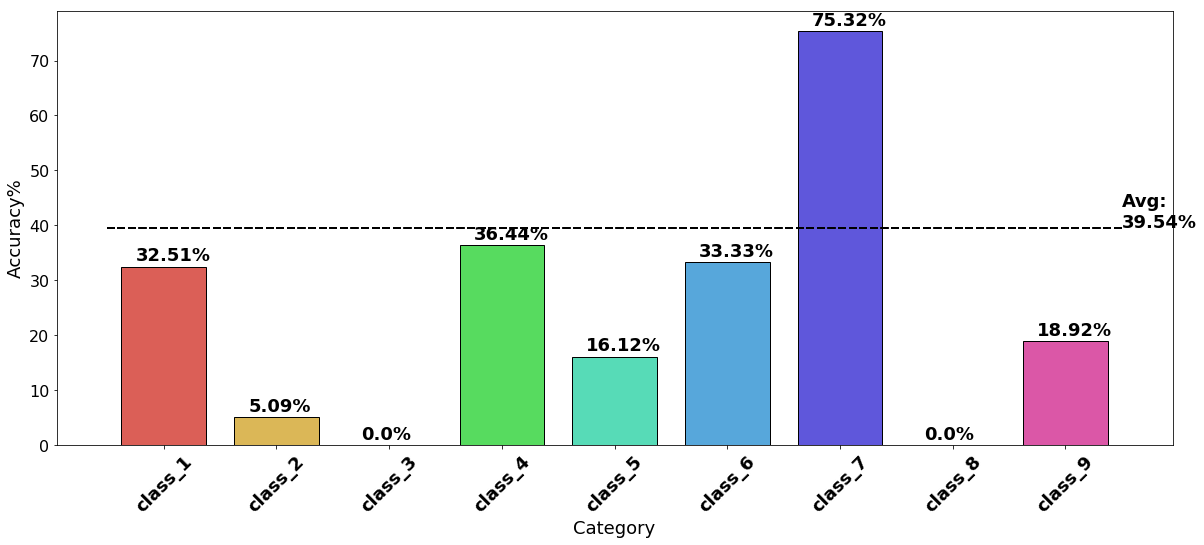

In [53]:
plot_acc_bar(cm,total_acc=39.54)

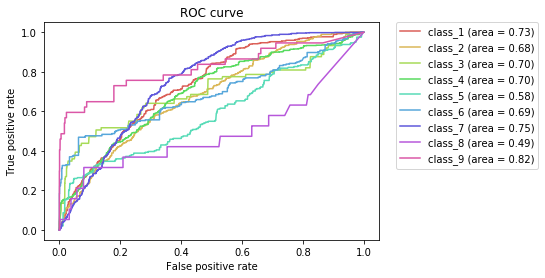

In [54]:
plot_ROC_curve(output)

<a id='Part2.5.4_link'></a>
### 2.5.4 XGBClassifier

https://xgboost.readthedocs.io/en/latest/parameter.html
<br>Important hyperparameters for **XGBClassifier**:
1. **eta** (learning_rate, default=0.3)
2. **gamma** (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
3. **max_depth** (default=6): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
4. **min_child_weight** (default=1): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
5. **colsample_bytree** (default=1): The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

<a id='Part2.5.4.1_link'></a>
### 2.5.4.1 validation_curve

* Model: XGBClassifier

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.82215601 0.83399208 0.83708409 0.83904443 0.84145784]
test_mean: [0.41034383 0.39888037 0.40074068 0.39530289 0.39230533]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.41034382761181964
--------------------------------------------------------------------------------


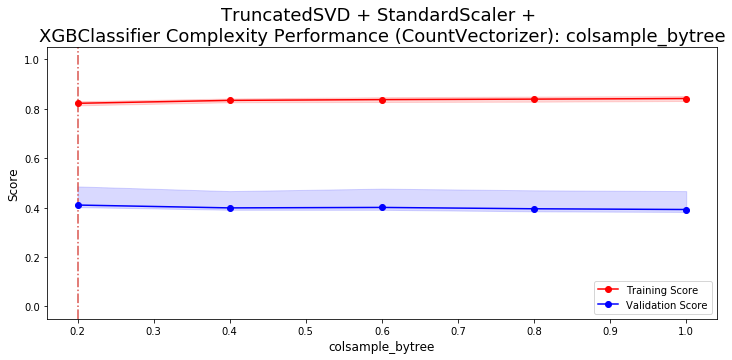

In [55]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='TruncatedSVD + StandardScaler + \nXGBClassifier Complexity Performance (CountVectorizer): colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.84145784 0.83301399 0.82411625 0.81861415 0.81393323 0.79803035]
test_mean: [0.39230533 0.39532052 0.40014126 0.39471181 0.39142393 0.38835469]
--------------------------------------------------------------------------------
min_child_weight: 5 achieves highest test score: 0.40014126484845275
--------------------------------------------------------------------------------


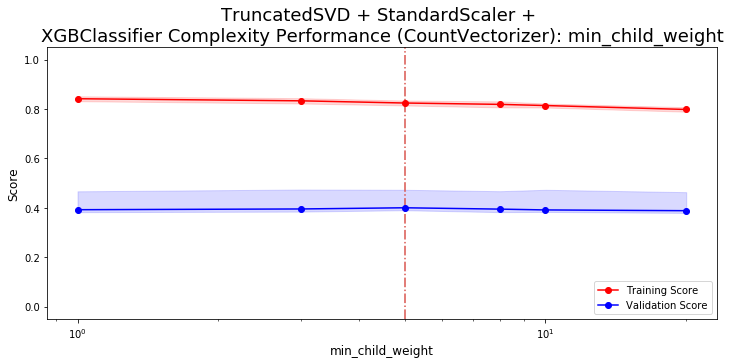

In [56]:
X=train_set
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')
title='TruncatedSVD + StandardScaler + \nXGBClassifier Complexity Performance (CountVectorizer): min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=True)

## Conclusion for LSA + Gene Variation

1. The overall training performance for LSA method with gene variation information is not better than LSA or BOW method, with overall validation accuracy around 0.40.
2. The n_components value in **TruncatedSVD** for both gene variation and text conversion needs to be optimized.